# Prediction of phase separation propensities of disordered proteins from sequence

Code to reproduce figures in <br> *von Bülow, S., Tesei, G., & Lindorff-Larsen, K. (2024). Prediction of phase separation propensities of disordered proteins from sequence. bioRxiv.*

The notebook requires the CALVADOS package, available in the same repository.


# Import and functions

In [1]:
from calvados import sequence, build, analysis, slab_conc
from calvados.sequence import SeqFeatures
from calvados.predictor import *

import numpy as np
import pandas as pd
import numba as nb

import os
import MDAnalysis as mda
import matplotlib.pyplot as plt

from scipy.stats import linregress, sem, spearmanr
from scipy.spatial.distance import mahalanobis
from scipy.optimize import curve_fit

from itertools import combinations

from tqdm import tqdm
from joblib import dump, load
import yaml

import cProfile
import pstats

import warnings
warnings.simplefilter("ignore")

cwd = os.getcwd()
cwd

/Users/sobuelow/miniconda3/envs/skl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/Users/sobuelow/projects/learn_csat/paper/_2024_buelow_PSpred'

In [2]:
flib = '/Users/sobuelow/calvados'
residues = pd.read_csv('data/residues.csv').set_index('one')
fcolor = plt.cm.summer
nu_file = 'models/svr_model_nu.joblib'

simulated = np.loadtxt('data/simulated.txt',dtype='int')

ah_intgrl_map = sequence.make_ah_intgrl_map(residues)
lambda_map = sequence.make_lambda_map(residues)

features = ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij','nu_svr']
features_full = ['N','mean_lambda','faro', 'shd','fcr','ncpr','scd', 'mw','ah_ij','kappa','nu_svr']

In [25]:
features_clean = {
    'mean_lambda' : r'$\bar{\lambda}$',
    'faro' : r'$f_\mathrm{aro}$',
    'shd' : 'SHD',
    'ncpr' : 'NCPR',
    'fcr' : 'FCR',
    'scd' : 'SCD',
    'ah_ij' : r'AH$_\mathrm{pairs}$',
    'q_ij' : r'q$_\mathrm{pairs}$',
    'nu_svr' : r'$\nu_\mathrm{SVR}$',
    'N' : 'N',
    'kappa' : r'$\kappa$',
    'mw' : r'M$_w$',
    'rg_rel' : r'$\overline{R}_{g,\text{Interface}}$' + ' / ' +r'$\overline{R}_{g,\text{Dense}}$',
    'sz' : r'$S_z$ (Interface)',
}

targets_clean = {
    'dG' : r'$\Delta G$ [kT]',
    'logcdil_mgml' : r'ln(c$_\mathrm{dil}$ [g/L])',
    'log10cdil_mgml' : r'log$_{10}$(c$_\mathrm{dil}$ [g/L])',
    'dG_pred_error' : r'$\Delta G$ Error [kT]',
}

mltypes_clean = {
    'svr' : 'SVR',
    'mlp' : 'Dense NN',
}

units_clean = {
    'dG' : r'k$_B$T',
    'logcdil_mgml' : ''
}

ora = plt.cm.viridis
colors = [ora(0.4), ora(0.7), ora(1.)]
alphas = [0.7, 0.6, 0.3]

In [4]:
def calc_cden_mgml(N,mw,val):
    box = build.calc_box(N)
    nprot = build.calc_nprot_slab(N,box)

    cbulk = nprot / (box[0] * box[1] * box[2]) / 6.022e23 * 1e24 * 1e3 # mM, bulk
    
    if val['dG'] == 0.:
        cden = cbulk
    elif val['cden'] < cbulk:
        cden = cbulk
    else:
        cden = val['cden']

    cden_mgml = cden * mw  / 1e3
    return cden, cden_mgml

def convert_cden(df):
    for key, val in df.iterrows():
        seq = val['fasta']
        N = len(seq)
        # calc mw
        mw = sequence.calc_mw(seq)
        df.loc[key,'mw'] = mw
        # convert cdil
        cden, cden_mgml = calc_cden_mgml(N,mw,val)
        df.loc[key,'cden'] = cden
        df.loc[key,'cden_mgml'] = cden_mgml
    return df

# Load all dataframes

In [5]:
# df_giulio = pd.read_csv('df_giulio.csv').set_index('seq_name')

df_full = pd.read_csv('data/IDRome_DB_full.csv').set_index('id')
# df = pd.read_csv('data/csv').set_index('id')

# df_ects = pd.read_csv('data/df_ects.csv').set_index('seq_name')
# df_giulio = pd.read_csv('df_giulio.csv').set_index('seq_name')

# Training data
df_merged = pd.read_csv('data/df_training.csv').set_index('seq_name')

# Skip simulations with two condensed phases
skiplist = ['Q5HYW3_413_569','P51861_1_262','Q9NYF8_1_593',
            'P98179_78_157','Q13936_420_515','Q1KMD3_636_747',
           'O60841_1_608','Q9NQX4_794_1370','Q9ULD5_260_638',
           'Q86VX9_1_247','Q14011_79_172',
            'P09651_187_372'] # Skip hnRNPA1 (exp. validation)

# Validation IDRome90
valid_intra_skiplist = ['P78332_1_467']
df_valid_intra = pd.read_csv('data/df_validation_IDRome90.csv').set_index('seq_name')
df_merged_with_intra = pd.concat([df_merged, df_valid_intra])

# Validation IDRome10
# df10 = pd.read_csv('IDRome_DB_10_features.csv').set_index('id')
valid_10_skiplist = ['Q9Y2H5_158_530','P38159_87_391']
df_valid_10 = pd.read_csv('data/df_validation_IDRome10.csv').set_index('seq_name')

# Validation exp. data
df_prots_ORE = pd.read_csv('data/df_prots_ORE.csv').set_index('name')

# Load ML Model

In [8]:
sim_sets = ['training', 'idrome90']
targets = ['dG','logcdil_mgml']#,'log10cdil_mgml','logcdil_mgml_norm']
mltypes = ['svr','mlp']

ncrossval = 50
C = 10
epsilon = 1e-2
alpha = 5
layers = (10,10)#(5,5)

models = {}
for sim_set in sim_sets:
    models[sim_set] = {}
    for mltype in mltypes:
        models[sim_set][mltype] = {}
        for target in targets:
            folder = f'models/{sim_set}/{mltype}/{target}'
            models[sim_set][mltype][target] = load(f'{folder}/model.joblib')

# Test model features and architecture

## Test feature combinations

In [13]:
# df_merged_with_intra

In [14]:
target = 'dG'

df_temp = df_merged_with_intra.copy()
df_temp = add_features(df_temp,features_full,residues=residues,nu_file=nu_file)
df_temp = df_temp[features_full + [target]].dropna()

maxfeatures = 2
print(f'maxfeatures: {maxfeatures}')

ncrossval = 50

mltype = 'mlp'
C = 10.
epsilon = 1e-2

alpha = 5
layers = (10,10)

vertical_bar = []
ct = 0
vertical_bar.append(0)

labels = []

rps = []
rp_stds = []
rmsds = []
rmsd_stds = []

rmax = 0.

for ncomp in range(1, maxfeatures+1):# len(featurestr)+1):
    for feats in combinations(features_full,ncomp):
        label = [features_clean[f] for f in feats]#feats
        labels.append(label)

        X, y, X_keys = makeXy(df_temp, feats, target=target)
        model = Model(
            mltype = mltype,
            C = C,
            epsilon = epsilon,
            ncrossval = ncrossval,
            alpha = alpha,
            layers = layers
        )
        model.train(X,y,X_keys,verbose=False)
        rp_std = np.std([cval.rp for cval in model.crossvals])
        rmsd_std = np.std([cval.rmsd for cval in model.crossvals])
        if model.rp_mean > rmax:
            print(f'>>>>>> {label}   P:{model.rp_mean:.4f}   S:{model.rs_mean:.4f}  RMSD:{model.rmsd_mean:.3f}')
            rmax = model.rp_mean
        rmsd_stds.append(rmsd_std)
        rmsds.append(model.rmsd_mean)
        rp_stds.append(rp_std)
        rps.append(model.rp_mean)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:24<00:00, 16.01it/s]


maxfeatures: 2
>>>>>> ['N']   P:0.1911   S:0.2049  RMSD:3.102
>>>>>> ['$\\bar{\\lambda}$']   P:0.4746   S:0.3569  RMSD:2.758
>>>>>> ['NCPR']   P:0.5884   S:0.5504  RMSD:2.533
>>>>>> ['N', '$f_\\mathrm{aro}$']   P:0.6058   S:0.5919  RMSD:2.503
>>>>>> ['$\\bar{\\lambda}$', 'NCPR']   P:0.6522   S:0.6209  RMSD:2.363
>>>>>> ['$\\bar{\\lambda}$', 'SCD']   P:0.6676   S:0.6239  RMSD:2.323
>>>>>> ['$\\bar{\\lambda}$', '$\\nu_\\mathrm{SVR}$']   P:0.7571   S:0.7434  RMSD:2.018
>>>>>> ['SHD', '$\\nu_\\mathrm{SVR}$']   P:0.7631   S:0.7342  RMSD:2.061
>>>>>> ['AH$_\\mathrm{pairs}$', '$\\nu_\\mathrm{SVR}$']   P:0.7878   S:0.7800  RMSD:1.924


In [15]:
# Results for final model (to compare)
model = models['idrome90']['mlp']['dG']
rp_full = model.rp_mean
rmsd_full = model.rmsd_mean
rmsd_std_full = np.std([cval.rmsd for cval in model.crossvals])
rp_std_full = np.std([cval.rp for cval in model.crossvals])

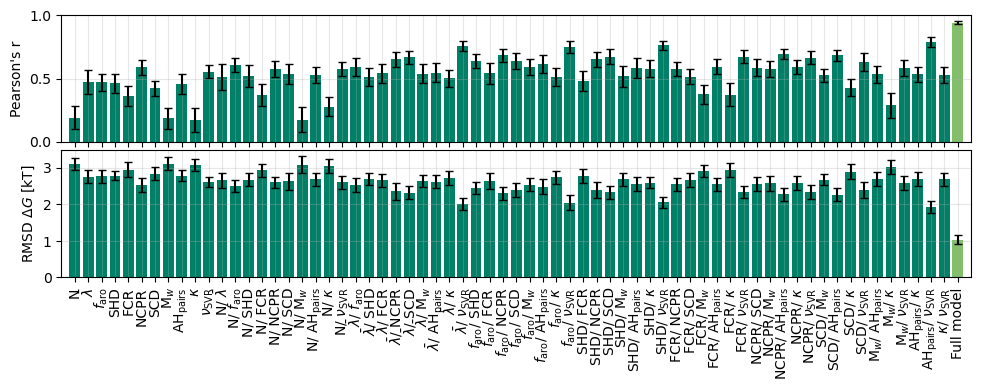

In [16]:
fig, ax = plt.subplots(2,1,figsize=(10,4),sharex=True)
xs = np.arange(len(labels)+1)
ax[0].bar(xs[:-1], rps, color=fcolor(0))
ax[0].errorbar(xs[:-1],rps,yerr=rp_stds,color='black',capsize=3,ls='none')
ax[0].bar(xs[-1], model.rp_mean, color=fcolor(0.5))
ax[0].errorbar(xs[-1],model.rp_mean,yerr=rp_std_full,color='black',capsize=3,ls='none')
ax[1].bar(xs[:-1], rmsds, color=fcolor(0))
ax[1].errorbar(xs[:-1],rmsds,yerr=rmsd_stds,color='black',capsize=3,ls='none')
ax[1].bar(xs[-1], model.rmsd_mean, color=fcolor(0.5))
ax[1].errorbar(xs[-1],model.rmsd_mean,yerr=rmsd_std_full,color='black',capsize=3,ls='none')

for idx in range(2):
    ax[idx].grid(alpha=0.3)

ax[1].set_xticks(xs)
labels_full = labels + [['Full model']]
ax[1].set_xticklabels(["/ ".join(l) for l in labels_full], rotation=90, fontsize=10)
ax[1].set(xlim=(xs[0]-1,xs[-1]+1))
ax[0].set(ylabel="Pearson's r")
ax[1].set(ylabel=f'RMSD {targets_clean["dG"]}')
fig.tight_layout(h_pad=0)

## Scan network architectures

In [ ]:
ncrossval = # 100

mltype = 'mlp'
alphas = [1,5,10,20]
layers_selection = [
    (1),
    (5),
    (10),
    (20),
    (1,1),
    (5,5),
    (10,10),
    (20,20)
]

rmax = 0.

print(features)
hyperparam_search = {}

for target in ['dG','logcdil_mgml']:
    df_temp = df_merged_with_intra[features + [target]].dropna()
    X, y, X_keys = makeXy(df_temp, features, target=target)
    
    rmsds = []
    rmsd_stds = []
    labels = []
    
    for layers in layers_selection:
        print('=============')
        print(f'layers: {layers}')
        print('--------------')
        for alpha in alphas:
            print(f'alpha: {alpha}')
            model = Model(
                mltype = mltype,
                alpha = alpha,
                layers = layers,
                ncrossval = ncrossval
            )
            model.train(X,y,X_keys,verbose=False)
            rmsd_std = np.std([cval.rmsd for cval in model.crossvals])
            if model.rp_mean > rmax:
                print(f'>>> P:{model.rp_mean:.3f}   S:{model.rs_mean:.3f}  RMSD:{model.rmsd_mean:.2f}')
                rmax = model.rp_mean
            else:
                print(f'P:{model.rp_mean:.3f}   S:{model.rs_mean:.3f}  RMSD:{model.rmsd_mean:.2f}')
            rmsds.append(model.rmsd_mean)
            rmsd_stds.append(rmsd_std)
            labels.append(r'$\alpha =$'+f'{alpha}'+r',  hl$=$'+f'{layers}')

    hyperparam_search[target] = {
        'labels' : labels,
        'rmsds' : rmsds,
        'rmsd_stds' : rmsd_stds
    }

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,5),sharex=True)

for idx, (tar, val) in enumerate(hyperparam_search.items()):
    axij = ax[idx]
    xs = np.arange(len(val['rmsds']))
    axij.bar(xs,val['rmsds'],color=fcolor(0))
    axij.errorbar(xs,val['rmsds'],yerr=val['rmsd_stds'],color='black',capsize=3,ls='none')
    axij.set_xticks(xs)
    axij.set_xticklabels(val['labels'],rotation=90)
    axij.set(ylabel=f'RMSD {targets_clean[tar]}')
    axij.grid(alpha=0.3)
fig.tight_layout()

## Scatter plot crossvalidation

In [ ]:
ranges = {
    'sim' : {
        'dG' : (-10.5, 0.4),
        'logcdil_mgml' : (-4.2,4.9)
    },
    'svr' : {
        'dG' : (-11, 4),
        'logcdil_mgml' : (-5,7)
    },
    'mlp' : {
        'dG' : (-11, 1),
        'logcdil_mgml' : (-5,5.2)
    }
}

In [ ]:
for sim_set in sim_sets:
    for mltype in mltypes:
        for target in targets:
            # maxy = 0
            scatterdict_sim = {}
            scatterdict_pred = {}

            model = models[sim_set][mltype][target]
            
            for idx, crosv in enumerate(model.crossvals):
                for name, ysim, ypred in zip(crosv.X_test_keys, crosv.y_test, crosv.ypred_test):
                    # my = np.max(ypred)
                    # if my > maxy:
                    #     maxy=my
                    if name not in scatterdict_pred:
                        scatterdict_pred[name] = []
                    scatterdict_sim[name] = ysim
                    scatterdict_pred[name].append(ypred)

            fig, ax = plt.subplots(figsize=(3.5,3))
            for name, ysim in scatterdict_sim.items():
                ax.plot(ysim, np.mean(scatterdict_pred[name]),'o',color=fcolor(0),markersize=4)
                if sim_set == 'idrome90' and mltype == 'mlp' and target == 'dG':
                    df_merged_with_intra.loc[name,'dG_pred'] = np.mean(scatterdict_pred[name])
                # if (ysim == 0.) and np.mean(scatterdict_pred[name]) < -2:
                    # print(name)
            ax.text(np.min(crosv.y_train),ranges[mltype][target][1]-0.5,#np.max(crosv.ypred_train),
                    f'Pearson r: {model.rp_mean:.2f} \nRMSD: {model.rmsd_mean:.2f}',
                   verticalalignment='top')
            ax.set_title('Cross-validation',fontsize=10)#mltypes_clean[mltype])
            # xs = np.arange(ranges[mltype][target][0],ranges[mltype][target][1]+0.1,0.1)
            ax.plot(np.min(scatterdict_sim).values(),np.max(scatterdict_sim).values(),color='black',lw=1.)
            # ax.plot(xs,xs,color='black')#,ls='dashed')
            ax.set(xlabel=f'{targets_clean[target]} Simulation', ylabel=f'{targets_clean[target]} {mltypes_clean[mltype]}')
            ax.set(xlim=(ranges['sim'][target]), ylim=(ranges[mltype][target]))
            ax.grid(alpha=0.3)
            fig.tight_layout()
            # fig.savefig(f'figures/scatter/scatter_crossval_{sim_set}_{mltype}_{target}.pdf')

## Error model

In [ ]:
df_merged_with_intra['dG_pred_error'] = np.abs(df_merged_with_intra['dG_pred'] - df_merged_with_intra['dG'])

features_tmp = features + ['dG_pred']

print(f'features: {features_tmp}')

target = 'dG_pred_error'#'logcdil_mgml'#'dG'
target_clean = target

print(f'target: {target}')

print(target)
df_temp = df_merged_with_intra[features_tmp + [target]].dropna()
print(len(df_temp))

ncrossval = 50

X, y, X_keys = makeXy(df_temp, features_tmp, target=target)
# X_full, X_full_keys = makeXy(df, features) # full IDRome selected features

mltype = 'svr' # 'svr'
C = 10
epsilon = 1e-2
alpha = 5
layers = (10,10)#(5,5)

model = Model(
    mltype = mltype,
    C = C,
    epsilon = epsilon,
    layers = layers,
    alpha = alpha,
    ncrossval = ncrossval
)
print(model.layers, model.alpha)
model.train(X,y,X_keys,verbose=False)

print(f'P:{model.rp_mean:.3f}   S:{model.rs_mean:.3f}  RMSD:{model.rmsd_mean:.2f}')

scatterdict_sim = {}
scatterdict_pred = {}

for idx, crosv in enumerate(model.crossvals):
    for name, ysim, ypred in zip(crosv.X_test_keys, crosv.y_test, crosv.ypred_test):
        if name not in scatterdict_pred:
            scatterdict_pred[name] = []
        scatterdict_sim[name] = ysim
        scatterdict_pred[name].append(ypred)

for name, ysim in scatterdict_sim.items():
    df_merged_with_intra.loc[name,'dG_pred_error_pred'] = np.mean(scatterdict_pred[name])

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(8,3))

ax[0].plot(df_merged_with_intra['dG_pred_error'],df_merged_with_intra['dG_pred_error_pred'],'o',color=fcolor(0),markersize=4)
ax[1].plot(df_merged_with_intra['dG'],df_merged_with_intra['dG_pred_error'],'o',color=fcolor(0),markersize=4)
ax[2].plot(df_merged_with_intra['dG'],df_merged_with_intra['dG_pred_error_pred'],'o',color=fcolor(0),markersize=4)
ax[0].plot(np.min(scatterdict_sim).values(),np.max(scatterdict_sim).values(),color='black',lw=1.)
ax[0].set(xlabel=f'{targets_clean[target]} Simulation', ylabel=f'Predicted {targets_clean[target]}')
ax[1].set(xlabel=f'{targets_clean["dG"]} Simulation', ylabel=f'{targets_clean[target]} Simulation')
ax[2].set(xlabel=f'{targets_clean["dG"]} Simulation', ylabel=f'Predicted {targets_clean[target]}')

# ax.set(xlim=(ranges['sim'][target]), ylim=(ranges[mltype][target]))
for idx in range(3):
    ax[idx].set(ylim=(-0.1,3))
    # ax[idx].set(ylim=(-3,3))
    ax[idx].grid(alpha=0.3)
# ax[0].set(xlim=(-0.2,4))
fig.tight_layout()

# Predict single value

In [ ]:
model = models['idrome90']['mlp']['dG']

# FUS LCD
seq = '''MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYS
SYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQS
SSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNS'''.replace('\n','')

X = X_from_seq(seq,features,residues=residues,charge_termini=True,nu_file=nu_file)
ys = model.predict(X)#,models)
print(np.mean(ys))

## Validation experimental data

Tesei et al., Open Research Europe (ORE) (2022):

*Improved Predictions of Phase Behaviour of Intrinsically Disordered Proteins by Tuning the Interaction Range*

In [ ]:
ORE_naming = {
    'P23GM23SM12FP12Y' : r'A1$^\mathrm{23xSG,12xFY}$',
    'P23GM23SP7FM7Y' : r'A1$^\mathrm{23xSG,7xYF}$',
    'P23GM23S' : r'A1$^\mathrm{23xSG}$',
    'M10GP10S' : r'A1$^\mathrm{10xGS}$',
    'A1S150' : r'A1$^*$',
    'M20GP20S' : r'A1$^\mathrm{20xGS}$',
    'M30GP30S' : r'A1$^\mathrm{30xGS}$',
    'M14NP14Q' : r'A1$^\mathrm{14xNQ}$',
    'M23SP23T' : r'A1$^\mathrm{23xST}$',
    'M12FP12Y' : r'A1$^\mathrm{12xFY}$',
    'P7FM7Y' : r'A1$^\mathrm{7xYF}$',
}

### Predict ORE data

### Compare saturation concentration to exp

In [ ]:
target = 'logcdil_mgml'
model = models['idrome90']['mlp'][target]

print(features)
df_temp_ORE = df_prots_ORE.dropna() # data including exp
# models = results['models']

plotlog = True

fig, ax = plt.subplots(figsize=(3.5,3))

xs = np.arange(-2.5,2.6,0.1)
ax.plot(xs,xs,color='black',lw=1.5)

# fig, ax = plt.subplots(figsize=(4,3))
# for name, ysim in vv_ORE[target].items():
X_ORE, yexp_ORE, X_ORE_keys = makeXy(df_temp_ORE, features, target='exp_logcdil_mgml') 

ysim_ORE = df_temp_ORE['sim_logcdil_mgml']

ypred_ORE = model.predict(X_ORE)
ypred_ORE_m = np.mean(ypred_ORE,axis=0)
print('exp to sim:')
model.calc_statistics(yexp_ORE,ysim_ORE) # to sim
print('exp to model:')
model.calc_statistics(yexp_ORE,ypred_ORE_m) # to exp

ax.plot(yexp_ORE, ysim_ORE,'x',color='black',label='Simulation')
ax.plot(yexp_ORE, ypred_ORE_m,'o',color='black',label=mltypes_clean[mltype])#,fillstyle='none')

for yexp, ysim, ypred, key in zip(yexp_ORE, ysim_ORE, ypred_ORE_m, X_ORE_keys):
    print(key)
    if 'LAF1' in key:
        color = fcolor(0.4)
    else:
        color = fcolor(0)
    ax.plot(yexp, ysim,'x',color=color)#, label='Calvados simulation')
    ax.plot(yexp, ypred,'o',color=color)#,fillstyle='none')

# for yexp, ypred, key in zip(yexp_ORE, ypred_ORE_m, X_ORE_keys):
#     ax.plot(yexp, ypred,'o',color=color)
ax.text(-2,0,'A1 variants',color=fcolor(0))
ax.text(-2,-2.3,'LAF1 variants',color=fcolor(0.6))

ax.set(xlabel=f'{targets_clean[target]} Experiment', ylabel=f'{targets_clean[target]} Prediction')
ax.set_title('A1 / LAF1 LCD variants',fontsize=10)
# ax.text(1,-0.5,'Simulation',color='tab:blue')
# ax.text(1,0.2,'ML Prediction',color='C1')
# ax.set(xlabel=r'Experimental concentration [log(mg/mL)]', ylabel='Predicted concentration [log(mg/mL)]')

# ax.set(xlabel='dG simulated (ORE)', ylabel='dG predicted')
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
# fig.savefig(f'figures/ORE/ORE_{target}_nolabel.pdf')

### Compare dG to simulation

In [ ]:
target = 'dG'
mltype = 'mlp'
model = models['idrome90'][mltype][target]

print(features)
df_temp_ORE = df_prots_ORE.dropna() # data including exp
# models = results['models']

plotlog = True

fig, ax = plt.subplots(figsize=(3.5,3))
# for name, ysim in vv_ORE[target].items():
X_ORE, ysim_ORE, X_ORE_keys = makeXy(df_temp_ORE, features, target=target) 

ypred_ORE = model.predict(X_ORE)
ypred_ORE_m = np.mean(ypred_ORE,axis=0)

print('sim to model:')
model.calc_statistics(ysim_ORE,ypred_ORE_m) # to exp

ax.plot(ysim_ORE,ysim_ORE,color='black',ls='solid')

# ax.plot(ysim, ysim_ORE,'o',color='C0', label='C2 simulated')
for ysim, ypred, key in zip(ysim_ORE, ypred_ORE_m, X_ORE_keys):
    if 'LAF1' in key:
        color= fcolor(0.4)
    else:
        color = fcolor(0)
    if key in ['M30GP30S','M14NP14Q']:
        alig = 'right'
        offset = -0.0
    else:
        alig = 'left'
        offset = 0.05
        # alig = 'left'
        # offset = 0.1
    # else:
    if key in ['M12FP12Y','P7FM7Y','M23SP23T','A1']:
        yoffset = -0.25
    else:
        yoffset = 0.
    # if len(key)
    ax.plot(ysim, ypred,'o',color=color)
    if key in ORE_naming:
        text = ORE_naming[key]
    else:
        text = key
    # ax.text(ysim+offset, ypred+yoffset, text, fontsize=12, horizontalalignment=alig, color=color)#, c=f'C0')
ax.text(-8,-5.6,'A1 variants',color=fcolor(0))
ax.text(-5.5,-6.6,'LAF1 variants',color=fcolor(0.4))
ax.set(xlabel=f'{targets_clean[target]} Simulation', ylabel=f'{targets_clean[target]} {mltypes_clean[mltype]}')
ax.set_title('A1 / LAF1 LCD variants',fontsize=10)
ax.grid(alpha=0.3)

fig.tight_layout()

# Convergence

## Cross-validation convergence

In [ ]:
def prep_convergence(df_input, df_full, features, simulated, target):
    df_temp = df_input[features + [target]].dropna()
    
    print(len(simulated))
    simulated_clean = [] # keys without skiplist
    for key in simulated:
        name = df_full.loc[key,'seq_name']
        if name not in skiplist:
            if name in df_temp.index:
                simulated_clean.append(key)
    print(len(simulated_clean))
    
    # Start from ECT + Giulio
    df_seed = df_temp.copy()
    # df_notseed = df_temp.copy()
    
    # define seed of ECT + Giulio
    for sim in simulated_clean:
        name = df_full.loc[sim,'seq_name']

        if name in df_temp.index:
            df_seed.drop(name,inplace=True)
    print(f'Number of seed simulations: {len(df_seed)}')
    return simulated_clean, df_temp, df_seed

In [ ]:
mltype = 'mlp'
target = 'logcdil_mgml'

print(target)
print(features)

simulated_clean, df_temp, df_seed = prep_convergence(df_merged, df_full, features, simulated, target)

In [ ]:
ncrossval = 30
verbose = False
fcolor = plt.cm.summer

alpha = 5
layers = (10,10)#(5,5)
C = 10.
epsilon = 1e-2

rps = []
rss = []
rmsds = []

models_tmp = []

ndfs = np.arange(0,len(simulated_clean)+1,5)

for idx, ndf in tqdm(enumerate(ndfs),total=len(ndfs)):
    df_reduced = df_seed.copy()

    for sim in simulated_clean[:ndf]:
        name = df_full.loc[sim,'seq_name']
        df_reduced.loc[name] = df_temp.loc[name]

    X, y, X_keys = makeXy(df_reduced, features, target=target)

    model = Model(
        mltype = mltype,
        C = C,
        epsilon = epsilon,
        layers = layers,
        alpha = alpha,
        ncrossval = ncrossval
    )

    model.train(X,y,X_keys,verbose=verbose)

    models_tmp.append(model)

    rps.append(model.rp_mean)
    rss.append(model.rs_mean)
    rmsds.append(model.rmsd_mean)

rps = np.array(rps)
rss = np.array(rss)
rmsds = np.array(rmsds)

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))#,sharey='col')#,sharex='col')

axij = ax
axtwin = axij.twinx()

axij.plot(ndfs+len(df_seed), rps[:], label='Pearson R',c=fcolor(0))

axtwin.plot(ndfs+len(df_seed), rmsds[:], label='rmsd', color='black')

axij.set(xlabel='Number of simulations')
axij.set_ylabel('Pearson r',color=fcolor(0))

axij.grid(alpha=0.3)

axtwin.set(ylabel=f'RMSD {targets_clean[target]}')
axij.yaxis.label.set_color(fcolor(0))
axij.tick_params(axis='y', colors=fcolor(0))

axij.set(title=mltypes_clean[mltype])

fig.tight_layout()

## Validation set (IDRome90) convergence

In [ ]:
mltype = 'mlp'
target = 'logcdil_mgml'#'dG'

print(target)
print(features)

simulated_clean, df_temp, df_seed = prep_convergence(df_merged, df_full, features, simulated, target)

df_temp_valid_intra = df_valid_intra[features + [target]].dropna()

In [ ]:
print(target)

ncrossval = 30
# nresample = 10
verbose = False
fcolor = plt.cm.summer

rps = []
rss = []
rmsds = []

y_vals = []
ypred_vals = []

ndfs = np.arange(0,len(simulated_clean)+1,5)

for idx, ndf in tqdm(enumerate(ndfs),total=len(ndfs)):
    # print(f'ndf: {ndf}')
    df_reduced = df_seed.copy()

    for sim in simulated_clean[:ndf]:
        name = df_full.loc[sim,'seq_name']
        df_reduced.loc[name] = df_temp.loc[name]

    X, y, X_keys = makeXy(df_reduced, features, target=target)
    X_val, y_val, X_val_keys = makeXy(df_temp_valid_intra, features, target=target)
    X_val_keys = np.array(X_val_keys,dtype='object')
    
    model = Model(
        mltype = mltype,
        C = C,
        epsilon = epsilon,
        layers = layers,
        alpha = alpha,
        ncrossval = ncrossval
    )
    model.train(X,y,X_keys,verbose=verbose)

    ypred_val = model.predict(X_val)

    outliers = np.where(np.abs(np.mean(ypred_val,axis=0) - y_val) > 3)[0]

    rp, rs, rmsd = model.calc_statistics_multimodel(y_val, ypred_val,verbose=verbose)

    rps.append(np.mean(rp))
    rss.append(np.mean(rs))
    rmsds.append(np.mean(rmsd))
    y_vals.append(y_val)
    ypred_vals.append(ypred_val)
        
rps = np.array(rps)
rss = np.array(rss)
rmsds = np.array(rmsds)
y_vals = np.array(y_vals)
ypred_vals = np.array(ypred_vals)

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))#,sharey='col')#,sharex='col')

axij = ax

axtwin = axij.twinx()

axij.plot(ndfs+len(df_seed), rps, label='Pearson R',c=fcolor(0))
axtwin.plot(ndfs+len(df_seed), rmsds, label='rmsd', color='black')

for jdx, ndf in enumerate(ndfs):
    yv_m = y_vals[jdx]
    yp = ypred_vals[jdx]
    yp_m = np.mean(yp,axis=0)
    yp_std = np.std(yp,axis=0)

axij.set(xlabel='Number of simulations')
axij.set_ylabel('Pearson r',color=fcolor(0))

axij.grid(alpha=0.3)

axtwin.set(ylabel=f'RMSD {targets_clean[target]}')
axij.yaxis.label.set_color(fcolor(0))
axij.tick_params(axis='y', colors=fcolor(0))

axij.set(title=mltypes_clean[mltype])

fig.tight_layout()

# Validation scatter plots

## IDRome90 (27 sequences)

In [ ]:
sim_set = 'training'
target = 'dG'#'logcdil_mgml' #'dG'
mltype = 'mlp'
model = models[sim_set][mltype][target]

X, y, X_keys = makeXy(df_valid_intra, features, target=target)

ypred = model.predict(X)
ypred_m = np.mean(ypred,axis=0)

rp, rs, rmsd = model.calc_statistics(y,ypred_m)
print(rp)

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(y, ypred_m,'o',color=fcolor(0))
ax.set(xlabel=f'{targets_clean[target]} Simulation',ylabel=f'{targets_clean[target]} {mltypes_clean[mltype]}')
ax.plot(y,y,color='black',lw=1.)#,ls='dashed')

ax.text(np.min(y),np.max(y),
        f'Pearson: {rp:.3f} \nRMSD: {rmsd:.2f}',
       verticalalignment='top')
# ax.legend(fontsize=8,ncols=2)
ax.grid(alpha=0.3)
ax.set_title(r'IDRome$_{90}$')
fig.tight_layout()

## IDRome 10 (26 sequences)

In [ ]:
sim_set = 'idrome90'
target = 'dG'#'logcdil_mgml'
mltype = 'mlp'
model = models[sim_set][mltype][target]

X, y, X_keys = makeXy(df_valid_10, features, target=target)
ypred = model.predict(X)
ypred_m = np.mean(ypred,axis=0)

fig, ax = plt.subplots(figsize=(3.5,3))
rp, rs, rmsd = model.calc_statistics(y,ypred_m)

ax.text(np.min(y),np.max(y),
        f'Pearson: {rp:.3f} \nRMSD: {rmsd:.2f}',
       verticalalignment='top')

ax.plot(y,y,color='black',lw=1.)
ax.plot(y,ypred_m,'o',color=fcolor(0))
ax.set(xlabel=f'{targets_clean[target]} Simulation',ylabel=f'{targets_clean[target]} {mltypes_clean[mltype]}')
ax.grid(alpha=0.3)
ax.set_title(r'IDRome$_{10}$',fontsize=10)
fig.tight_layout()

if target == 'dG':
    df_valid_10.loc[X_keys,'dGpred'] = ypred_m

# Features vs. dG

In [ ]:
limits = {
    'scd' : [-5,6],
    'ncpr' : [-0.25, 0.25],
    'kappa' : [0.0, 0.8],
    'faro' : [0.0, 0.15],
    'nu' : [0.2, 0.7],
    'nu_svr' : [0.45, 0.62],
    'mw' : [0., 60000],
    'fcr' : [0., 0.6],
    'mean_lambda' : [0.3, 0.6],
    'shd' : [1.5, 6.],
    'N' : [0, 800],
    'ah_ij' : [-0.9,-0.3],
}

## 1D plots

In [ ]:
target = 'dG'

nbins = 85

fcolor_r = plt.cm.summer_r

Nfeat = len(features)

fig, ax = plt.subplots(2,4,figsize=(10,4),sharey=True)

for idx, feat in enumerate(features):
    axij = ax[idx//4,idx%4]
    
    xs = df_full[feat].to_numpy()
    ys = df_full['dG_pred'].to_numpy()
    if feat in limits:
        drange = limits[feat]
    else:
        drange = None
    edges, y_binned = bin_data(xs,ys,nbins,drange=drange)
    edges = (edges[:-1] + edges[1:]) / 2.

    y_mean = np.array([np.mean(y) for y in y_binned])
    y_std = np.array([np.std(y) for y in y_binned])
    yLs = np.array([len(yb) for yb in y_binned])

    for e, ym, ys, yL in zip(edges,y_mean,y_std,yLs):
        color = fcolor_r(max(0.1,yL/(1.05*max(yLs))))
        markers, caps, bars = axij.errorbar(e,ym,yerr=ys,capsize=3,marker='o',markersize=3,color=color,zorder=10)

        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]

    ax2 = axij.twinx()
    ax2.plot(edges,yLs,lw=0.8,alpha=0.4,color='black')
    ax2.fill_between(edges,yLs,alpha=0.3,color='black')
    if idx in [3,7]:
        ax2.set(ylabel='IDR Frequency')

    ax2.set(ylim=(0,max(yLs)*3))
    # ax2.set_yticks([])
    ax2.set_yticklabels([])
    
    axij.set(xlabel=features_clean[feat])
    axij.tick_params(axis='y', colors=fcolor_r(0.99))
    axij.grid(ls='dotted',alpha=0.5)

for idx in range(2):
    ax[idx,0].set_ylabel(f'{targets_clean[target]} {mltypes_clean[mltype]}',color=fcolor_r(0.99))
fig.tight_layout()

## 2D plots

In [ ]:
def select_bin(x,bins,nbins):
    if x < bins[0]:
        return -100
        # bin_idx = 0
    elif x > bins[-1]:
        return -100
        # bin_idx = nbins-1
    else:
        for idx in range(nbins):
            if x >= bins[idx] and x <= bins[idx+1]:
                bin_idx = idx
    return bin_idx

def bin_data_2d(xs0, xs1, ys, nbins, dranges=None):
    if dranges == None:
        xmin0, xmax0 = np.min(xs0), np.max(xs0)
        xmin1, xmax1 = np.min(xs1), np.max(xs1)
    else:
        xmin0, xmax0 = dranges[0][0], dranges[0][1]
        xmin1, xmax1 = dranges[1][0], dranges[1][1]
    
    bins0 = np.linspace(xmin0,xmax0,nbins+1)
    bins1 = np.linspace(xmin1,xmax1,nbins+1)
    y_binned = []
    # y_binned = [[] for _ in range(nbins)]
    for idx in range(nbins):
        y_binned.append([[] for _ in range(nbins)])

    for x0, x1, y in zip(xs0, xs1, ys):
        bin_idx0 = select_bin(x0,bins0,nbins)
        bin_idx1 = select_bin(x1,bins1,nbins)
        if (bin_idx0 >= 0) and (bin_idx1 >= 1):
            y_binned[bin_idx0][bin_idx1].append(y)

    y_binned_m = np.zeros((nbins,nbins))
    
    for idx in range(nbins):
        for jdx in range(nbins):
            y_binned_m[idx,jdx] = np.mean(y_binned[idx][jdx])
    return bins0, bins1, y_binned_m

In [ ]:
features_2d = features.copy()

ys = df_full['dG_pred']

nbins = 60
vmin = -7
vmax = 0.

idx_offset = 0

fig, ax = plt.subplots(2,4,figsize=(12,4))#,width_ratios=[1,1,1,2])

feat0 = 'mean_lambda'

xs0 = df_full[feat0].to_numpy()
for idx, feat1 in enumerate(features_2d):
    if feat1 == feat0:
        idx_offset -= 1
        continue

    axij = ax[(idx+idx_offset)//4,(idx+idx_offset)%4]

    xs1 = df_full[feat1].to_numpy()

    dranges = [
        limits[feat0],
        limits[feat1]
    ]

    edges0, edges1, y_binned_2d = bin_data_2d(xs0, xs1, ys, nbins, dranges=dranges)

    _ = axij.imshow(y_binned_2d.T,extent=None,cmap=plt.cm.Spectral,origin='lower',
                   vmin=vmin,vmax=vmax)#,aspect='auto')

    # if (idx+idx_offset) in [3,6]:
    fig.colorbar(_,ax=axij,label=targets_clean[target])
    axij.set(xlabel=features_clean[feat0],ylabel=features_clean[feat1])

    xt = [0,nbins//2,nbins]#np.arange(0,nbins,20)
    axij.set_xticks(xt)
    axij.set_xticklabels([f'{e:.3f}' for e in edges0[xt]])
    axij.set_yticks(xt)
    axij.set_yticklabels([f'{e:.3f}' for e in edges1[xt]])

ax[-1,-1].set_visible(False)
fig.tight_layout(h_pad=0.1,w_pad=0.1)

# IDRome distribution

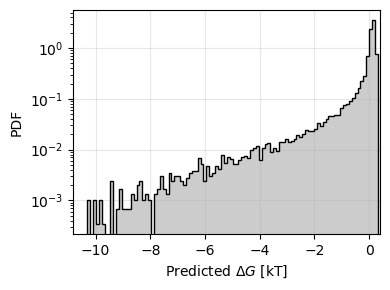

In [18]:
fig, ax = plt.subplots(figsize=(4,3))

target = 'dG'
model = models['idrome90']['mlp'][target]

# for idx, d in enumerate([df,df10]):
ax.hist(df_full['dG_pred'],bins=100,histtype='step',density=True,color='black')
ax.hist(df_full['dG_pred'],bins=100,alpha=0.2,density=True,color='black')

ax.set(yscale='log')
ax.grid(alpha=0.3)
ax.set(xlabel=f'Predicted {targets_clean[target]}',ylabel='PDF')
ax.set(xlim=(None,0.4))
# ax.legend()
fig.tight_layout()
# fig.savefig(f'figures/IDRome_{target}_distribution.pdf')

# Density maps, skipped plots

In [ ]:
skiplist_all = skiplist[:-1] + valid_intra_skiplist + valid_10_skiplist # Don't plot A1 here (only removed to avoid leaking into validation data

In [ ]:
from matplotlib.ticker import FormatStrFormatter
nskip = len(skiplist_all)

print(nskip)
fig, ax = plt.subplots(nskip//2,2,figsize=(10,0.8*nskip))#,height_ratios=np.ones((nskip//2)))#,width_ratios=np.ones((nskip)))#,sharey=True)
for idx, name in enumerate(skiplist_all):
    axij = ax[idx//2,idx%2]
    key = name_to_index(df_full,name)[0]

    hs = np.load(f'data/densitymaps_skipped/{name}.npy')

    print(name, hs.shape)

    if name in valid_10_skiplist:
        cmap = plt.cm.Reds
    else:
        cmap = plt.cm.Blues
    axij.pcolor(hs.T,cmap=cmap)#plt.cm.Blues)
    axij.set_title(name)
    axij.set(xlabel=r'Time [$\mu s$]')
    axij.set(ylabel='z [nm]')
    axij.set_anchor('W')

    axij.set_xticks(np.arange(0,hs.shape[0],200))
    xticklabels = np.arange(0,hs.shape[0]/100,2)
    axij.set_xticklabels([f'{xtl:.0f}' for xtl in xticklabels])
    # axij.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    axij.set_yticks(np.arange(0,hs.shape[1]+1,100))
    yticklabels = np.arange(-0.5*hs.shape[1]/10,0.5*hs.shape[1]/10+1,10)
    axij.set_yticklabels([f'{ytl:.0f}' for ytl in yticklabels])
fig.tight_layout(h_pad=1,pad=3)


# Monte-Carlo

In [ ]:
import random
def single_swap(seq,**kwargs):
    # seq = list(seq)
    step = kwargs['step']
    N = len(seq)
    for sidx in range(step):
        while True:
            i = random.choice(range(N))
            j = random.choice(range(N))
            if i != j and seq[i] != seq[j]:
                break
        seq = swap_pos(seq,i,j)
    return seq

def single_subst(seq,residues,step=1):
    N = len(seq)
    exclude_list = []
    for sidx in range(step):
        i = random.choice(range(N))
        seq = subst_pos(seq,i,residues)
    return seq

def swap_pos(seq,i,j):
    seq = list(seq)
    seq[i], seq[j] = seq[j], seq[i]
    seq = "".join(seq)
    return seq

def subst_pos(seq,i,residues):
    seq = list(seq)
    seqi = seq[i]
    while True:
        aa = random.choice(residues.index)
        if aa != seq[i]:
            seq[i] = aa
            break
    # print(f'subst {seqi} to {seq[i]}') 
    seq = "".join(seq)
    return seq
    # if (seq[i] in ['K','R','D','E']) or (seq[j] in ['K','R','D','E']):
    #     charge_swap = True
    # else:
    #     charge_swap = False

In [ ]:
def decide_action(pswap,psubst):
    r = np.random.random()
    if r <= pswap:
        return single_swap
    elif r <= pswap+psubst:
        return single_subst
    else:
        raise

def metropolis(u0,u1,a=100.):
    if u1 < u0:
        return True
    else:
        x = np.random.random()
        d = np.exp(a*(u0-u1))
        # print(x,d)
        if d > x:
            return True
        else:
            return False

def mc_energy(x, x_target, k=1.):
    # k = calc_kappa(seq)
    u = k*(x-x_target)**2
    return u

def check_constraint(x,x0,tolerance):
    check = np.abs(x-x0) <= tolerance
    return check

def set_constraint_defaults(constraints, seq_feats,verbose=True):
    for key, val in constraints.items():
        if val['value'] == None:
            tar = getattr(seq_feats,key)
            constraints[key]['value'] = tar
        else:
            tar = val['value']
        if verbose:
            print(f'setting {key} constraint target to {tar:.4f} +- {val["tolerance"]:.4f}')
    return constraints

def mc_along_diag(seq, features, residues, nu_file,
                  target, constraints,
                  model,
                  steps_per_iter = 5,
                  niter = 1000,
                  pswap = 0.5, psubst = 0.5,
                  a = 100., ah_intgrl_map = None,
                 lambda_map = None,
                 verbose=True):
    """ MC towards target """

    feature_values = {}
    for feat in features:
        feature_values[feat] = np.zeros((niter+1))

    us = np.zeros((niter+1))
    dGs = np.zeros((niter+1))
    seqs = []

    nswap, nsubst = 0, 0
    nacc_target, nacc_constraint = 0, 0

    seq_feats = SeqFeatures(seq,residues=residues,charge_termini=True,nu_file=nu_file,
                                         ah_intgrl_map=ah_intgrl_map,lambda_map=lambda_map)
    # print(seq_feats.scd)
    X = X_from_seq(seq,features,seq_feats=seq_feats)

    dG = np.mean(model.predict(X))
    nu = seq_feats.nu_svr

    # seq_feats.dG = dG
    # seq_feats.nu = nu

    seqs.append(seq)
    dGs[0] = dG
    
    for feat in features:
        feature_values[feat][0] = getattr(seq_feats,feat)

    # constr defaults
    constraints = set_constraint_defaults(constraints,seq_feats,verbose=verbose)

    if target['feat'] == 'dG':
        u = mc_energy(dG,target['value'],k=target['k'])
    else:
        raise
    us[0] = u
    
    for idx in range(1,niter+1):
        action = decide_action(pswap,psubst)
        seq_new = action(seq,residues=residues,step=steps_per_iter)
        seq_feats_new = SeqFeatures(seq_new,residues=residues,charge_termini=True,nu_file=nu_file,
                                                ah_intgrl_map=ah_intgrl_map, lambda_map=lambda_map)
        X = X_from_seq(seq_new,features,seq_feats=seq_feats_new)

        dG_new = np.mean(model.predict(X))
        nu_new = seq_feats_new.nu_svr

        # check target (Metropolis)
        if target['feat'] == 'dG':
            u_new = mc_energy(dG_new,target['value'],k=target['k'])
        elif target['feat'] == 'nu_svr':
            u_new = mc_energy(nu_new,target['value'],k=target['k'])
        else:
            raise
        accept_target = metropolis(u,u_new,a=a)
        if accept_target:
            nacc_target += 1

        # check constraints (hard cutoffs)
        accept_constraint = True
        for key, constr in constraints.items():
            accept_constraint = check_constraint(getattr(seq_feats_new,key), constr['value'], constr['tolerance'])
            if not accept_constraint:
                break
        if accept_constraint:
            nacc_constraint += 1
    
        if accept_target and accept_constraint:
            dG = dG_new
            u = u_new
            seq = seq_new
            seq_feats = seq_feats_new

        seqs.append(seq)
        dGs[idx] = dG
        us[idx] = u
        for feat in features:
            feature_values[feat][idx] = getattr(seq_feats,feat)

        # counters
        if action is single_swap:
            nswap += 1
        elif action is single_subst:
            nsubst += 1
    if verbose:
        print(f'nswap: {nswap}, nsubst: {nsubst}')
        print(f'nacc target: {nacc_target}, nacc constraint: {nacc_constraint}')
    # print(f'nacc_swap/nswap: {nacc_swap}/{nswap}, nacc_subst/nsubst: {nacc_subst}/{nsubst}')
    return seqs, dGs, us, feature_values

In [ ]:
df_lowdG = df_full.loc[df_full['dG_pred'] < -2]
len(df_lowdG)

In [ ]:
# Load nu, dG_pred
df_nu = df_full.loc[df_full['dG_pred'] > -4]
df_nu = df_nu.loc[df_nu['dG_pred'] < -1]
df_nu = df_nu.loc[df_nu['nu_svr'] < 0.5] # 0.53
# df_nu = df_nu.loc[df_nu['nu'] > 0.35] # 0.35

seq_names = df_nu['seq_name'].values
nus_all = df_nu['nu_svr'].values
dGs_all = df_nu['dG_pred'].values
seqs_all = df_nu['fasta'].values

## Constraint to nu and NCPR

In [ ]:
ah_intgrl_map = cal.sequence.make_ah_intgrl_map(residues)
lambda_map = cal.sequence.make_lambda_map(residues)

model = models['idrome90']['mlp']['dG']

steps_per_iter = 10
niter = 500
pswap = 1
psubst = 1. - pswap

constraints = {}
constraints['nu_svr'] = {
    'value' : None,
    'tolerance' : 0.001
}
constraints['ncpr'] = {
    'value' : None,
    'tolerance' : 0.002
}

target = {
    'feat' : 'dG',
    'value' : -10.,
    'k' : 0.3
}

nseqs = 20
verbose = True

diffs = {}
for feat in features:
    diffs[feat] = np.zeros((nseqs,niter+1))
diffs['dG'] = np.zeros((nseqs,niter+1))

seqs_subset = random.choices(seqs_all, k = nseqs)

for idx, seq in tqdm(enumerate(seqs_subset),total=len(seqs_subset)):
    for key in constraints.keys():
        constraints[key]['value'] = None
    # print(seq_names[idx], len(seq))
    seqs, dGs, us, feature_values = mc_along_diag(seq, features, residues, nu_file,
                      target, constraints, model,
                      steps_per_iter = steps_per_iter,
                      niter = niter,
                      pswap = pswap, psubst = psubst,
                      a = 100., ah_intgrl_map = ah_intgrl_map,
                      lambda_map=lambda_map,
                        verbose=verbose)
    if target['feat'] == 'dG':
        max_jdx = np.argmin(np.abs(target['value'] - dGs))
        diffs['dG'][idx] = dGs - dGs[0]
    for feat in features:
        diffs[feat][idx] = feature_values[feat] - feature_values[feat][0]

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(7,3.5),sharey=True)
for fidx, feat in enumerate(features):
    # if feat in ['nu_svr', 'ncpr']:
    #     continue
    axij = ax[fidx//4,fidx%4]
    # fig, ax = plt.subplots(figsize=(3,2))
    for idx, dfeat in enumerate(diffs[feat]):
        axij.plot(dfeat, diffs['dG'][idx],'-',color=fcolor(1-idx/(len(diffs))),markersize=4)
    axij.set(xlabel=r'$\Delta$'+f'{features_clean[feat]}')
    axij.axhline(0,c='black',ls='dashed')
    axij.axvline(0,c='black',ls='dashed')
    axij.grid(alpha=0.3)
    if feat in ['nu_svr','ncpr']:
        axij.set(xlim=(-0.005,0.005))
    if pswap == 1:
        xlim = axij.get_xlim()
        # print(xlim[0])
        axij.set(xlim=[np.min([-0.005,xlim[0]]),np.max([0.005,xlim[1]])])
ax[0,0].set(ylabel=r'$\Delta$$\Delta$G [kT]')
ax[1,0].set(ylabel=r'$\Delta$$\Delta$G [kT]')
fig.tight_layout()

In [ ]:
# Load nu, dG_pred
df_nu2 = df_full.loc[df_full['dG_pred'] < 10]
df_nu2 = df_nu2.loc[df_nu2['nu_svr'] < 10] # 0.53
nus_all2 = df_nu2['nu_svr'].values
dGs_all2 = df_nu2['dG_pred'].values

In [ ]:
viridis = plt.cm.viridis

fig, ax = plt.subplots(figsize=(3.,3.))

xs = np.arange(0.,1.01,0.01)

nus = feature_values['nu_svr']
ax.plot(nus_all2,dGs_all2,'.',color='gray',markersize=2)

for idx, seq in enumerate(seqs_subset):

    seq_feats = SeqFeatures(seq,residues=residues,charge_termini=True,nu_file=nu_file,
                                         ah_intgrl_map=ah_intgrl_map,lambda_map=lambda_map)
    X = X_from_seq(seq,features,seq_feats=seq_feats)

    nu_svr = seq_feats.nu_svr
    dG = np.mean(model.predict(X))
    
    nus = diffs['nu_svr'][idx] + nu_svr
    dGs = diffs['dG'][idx] + dG

    ax.plot(nus,dGs,'-',color=fcolor(idx/(len(diffs))),lw=3,markersize=6)

ax.set(xlim=(0.44,0.51),ylim=(-7,0))
ax.set(xlabel=r'$\nu_\mathrm{SVR}$',ylabel=r'$\Delta$G [kT]')

fig.tight_layout()

## Only swaps, no constraints

In [ ]:
# Load nu, dG_pred
df_nu = df_full.loc[df_full['dG_pred'] > -4]
df_nu = df_nu.loc[df_nu['dG_pred'] < -1]
df_nu = df_nu.loc[df_nu['nu_svr'] < 0.5] # 0.53

seq_names = df_nu['seq_name'].values
nus_all = df_nu['nu_svr'].values
dGs_all = df_nu['dG_pred'].values
seqs_all = df_nu['fasta'].values

In [ ]:
ah_intgrl_map = cal.sequence.make_ah_intgrl_map(residues)
lambda_map = cal.sequence.make_lambda_map(residues)

model = models['idrome90']['mlp']['dG']

steps_per_iter = 10
niter = 500
pswap = 1
psubst = 1. - pswap

constraints = {}
# constraints['nu_svr'] = {
#     'value' : None,
#     'tolerance' : 0.001
# }
# constraints['ncpr'] = {
#     'value' : None,
#     'tolerance' : 0.002
# }

target = {
    'feat' : 'dG',
    'value' : -10.,
    'k' : 0.#0.3
}

nseqs = 20
verbose = True

diffs = {}
for feat in features:
    diffs[feat] = np.zeros((nseqs,niter+1))
diffs['dG'] = np.zeros((nseqs,niter+1))

seqs_subset = random.choices(seqs_all, k = nseqs)

for idx, seq in tqdm(enumerate(seqs_subset),total=len(seqs_subset)):
    for key in constraints.keys():
        constraints[key]['value'] = None
    seqs, dGs, us, feature_values = mc_along_diag(seq, features, residues, nu_file,
                      target, constraints, model,
                      steps_per_iter = steps_per_iter,
                      niter = niter,
                      pswap = pswap, psubst = psubst,
                      a = 100., ah_intgrl_map = ah_intgrl_map,
                      lambda_map=lambda_map,
                        verbose=verbose)
    if target['feat'] == 'dG':
        max_jdx = np.argmin(np.abs(target['value'] - dGs))
        diffs['dG'][idx] = dGs - dGs[0]
    for feat in features:
        diffs[feat][idx] = feature_values[feat] - feature_values[feat][0]

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(7,3.5),sharey=True)

for fidx, feat in enumerate(features):

    axij = ax[fidx//4,fidx%4]
    for idx, dfeat in enumerate(diffs[feat]):
        axij.plot(dfeat, diffs['dG'][idx],'.',color=fcolor(1-idx/(len(diffs))),markersize=2)
    axij.set(xlabel=r'$\Delta$'+f'{features_clean[feat]}')
    axij.axhline(0,c='black',ls='dashed')
    axij.axvline(0,c='black',ls='dashed')
    axij.grid(alpha=0.3)

    if pswap == 1:
        xlim = axij.get_xlim()
        axij.set(xlim=[np.min([-0.005,xlim[0]]),np.max([0.005,xlim[1]])])
ax[0,0].set(ylabel=r'$\Delta$$\Delta$G [kT]')
ax[1,0].set(ylabel=r'$\Delta$$\Delta$G [kT]')
fig.tight_layout()

# Interface analysis

In [22]:
def calc_runavg(xs,N=10):
    xs_ravg = []
    for idx, x in enumerate(range(len(xs))):
        if x == np.nan:
            xs_ravg.append(np.nan)
        else:
            x0 = max(0,idx-N)
            x1 = min(len(xs), idx+N+1)
            y = np.nanmean(xs[x0:x1])
            xs_ravg.append(y)
    xs_ravg = np.array(xs_ravg)
    return xs_ravg

In [23]:
df_nu = pd.read_csv('data/df_nu.csv').set_index('seq_name')

## nu per region

110
0 37
37
37 74
37
74 111
36


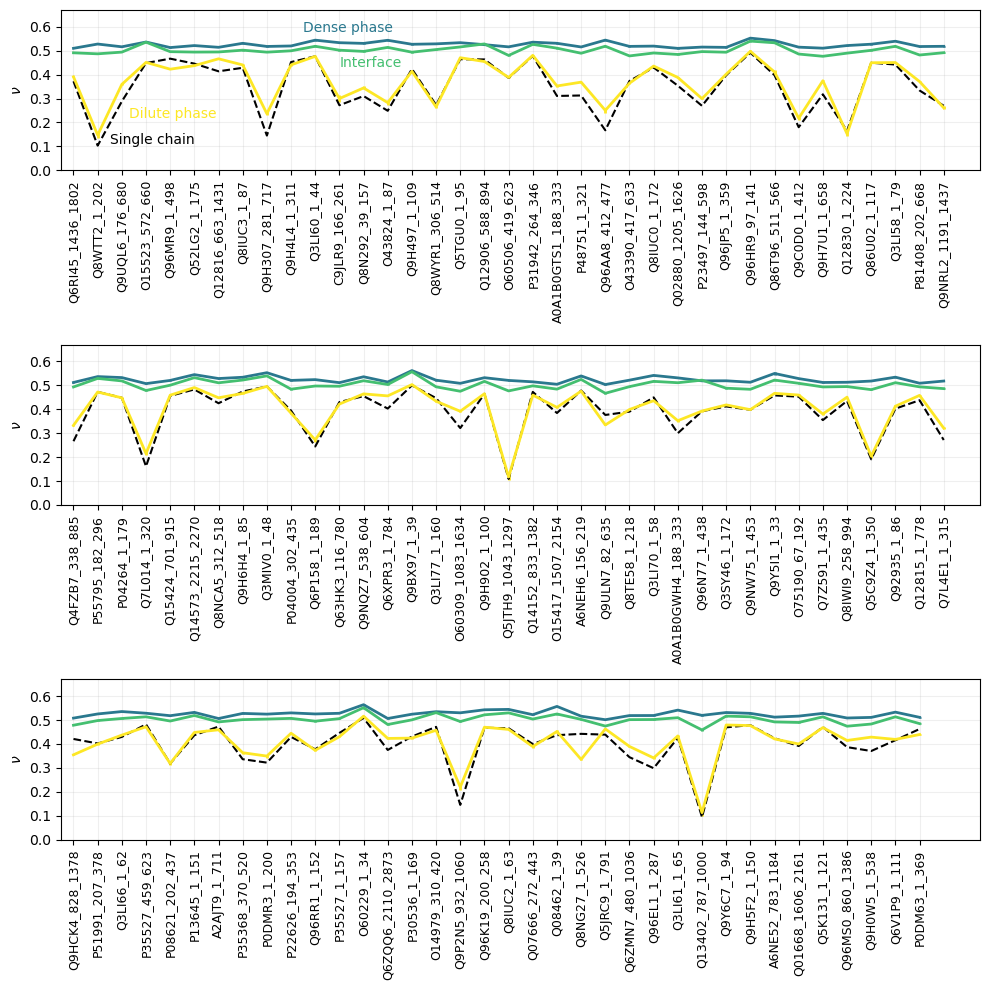

In [30]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

nseq = len(df_nu)
print(nseq)
for idx in range(3):
    axij = ax[idx]
    third = 37
    x0 = int(idx*third)#+1 # 141/3
    x1 = x0+int(third)
    print(x0,x1)
    
    xs = np.arange(len(df_nu))[x0:x1]
    print(len(xs))
    
    axij.errorbar(xs,df_nu['nu_dil'][x0:x1],yerr=df_nu['nu_dil_err'][x0:x1],label='dilute phase',color=colors[2],lw=2)#fcolor(0.))
    axij.errorbar(xs,df_nu['nu_den'][x0:x1],yerr=df_nu['nu_den_err'][x0:x1],label='dense phase',color=colors[0],lw=2)#fcolor(0.5))
    axij.errorbar(xs,df_nu['nu_inter'][x0:x1],yerr=df_nu['nu_inter_err'][x0:x1],label='intermediate phase',color=colors[1],lw=2)#'tab:orange')

    # axij.plot(xs,nus_single_list[x0:x1],label='single chain sim',c='black',ls='dashed')
    axij.plot(xs,df_nu['nu_single'][x0:x1],label='single chain sim',c='black',ls='dashed')
    
    axij.set(xlim=(x0-0.5,x1+0.5))
    axij.set(ylim=(0,0.67))
    axij.set_xticks(xs)
    axij.set_xticklabels(df_nu.index[x0:x1],rotation=90,fontsize=9)
    axij.grid(alpha=0.2)
    axij.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6])
    axij.set(ylabel=r'$\nu$')
    # ax.set_title(f'Scaling exponent for slab sims with dG < {dGmin}')

    # fig.savefig(f'figures/scaling_exp_dG_lt_{dGmin}.pdf')
ax[0].text(1.5,0.11,'Single chain',c='black',fontsize=10)
ax[0].text(2.3,0.22,'Dilute phase',c=ora(1.),fontsize=10)
ax[0].text(9.5,0.58,'Dense phase',c=colors[0],fontsize=10)
ax[0].text(11,0.43,'Interface',c=colors[1],fontsize=10)
fig.tight_layout()
# fig.savefig('figures/nu_per_phase.pdf')

In [ ]:
N = 0

names = []
cos_inter_minus_dense = []

for name, val in df_nu.iterrows():
    key = name_to_index(df_full,name)[0]
    fig, ax = plt.subplots(3,1,figsize=(4,4),height_ratios=[0.3,0.3,0.3],sharex=True)#len(simulated))

    p2 = np.load(f'{name}/293/p2s_mono.npy')
    p2 = np.where(p2!=0,p2,np.nan)
    p2 = calc_runavg(p2,N=N)
    
    xs = np.arange(len(p2))

    rgs = np.load(f'{name}/293/rgs_mono.npy')
    rgs = np.where(rgs!=0,rgs,np.nan)
    rgs = calc_runavg(rgs,N=N)

    ax0 = ax[0]
    ax0.set_title(f'{name}')#     dG={dG:.2f}')
    ax0.plot(xs,rgs,'-',c='black')#c=fcolor(0))#,label=r'$\nu$')
    ax0.set_ylabel(r'$R_g$')#,color=fcolor(0))
    ax0.grid(alpha=0.3)

    axcos = ax[1]
    axcos.plot(xs,p2,c='black')#fcolor(0.5))
    axcos.set_ylabel(r'<$P2[\cos(\theta)]$>')#,color=fcolor(0.5))
    axcos.grid(alpha=0.3)
    axcos.set(xlim=(0,len(p2)))

    if os.path.isfile(f'{name}/293/{name}.npy'):
        axh = ax[2]
        hs = np.load(f'{name}/293/{name}.npy')
        nhs = hs.shape[1]
        hs = np.mean(hs,axis=0)
        hs = hs[::10]
        nres = df_full.loc[key,'N']
        box = cal.build.calc_box(nres)
        mw = cal.sequence.calc_mw(df_full.loc[key,'fasta'])

        hs_mM, hs_mgml = cal.analysis.convert_h(hs,nres,box[0],mw)
        hs_uM = hs_mM*1000.
        axh.plot(hs_uM,color='black')
        axh.set_yscale('log')
        axh.grid(alpha=0.3)
        axh.set(xlabel='z [nm]')
        axh.set(ylabel=r'c [$\mu$M]')

    cutoffs_dense = np.load(f'{name}/293/cutoffs_dense.npy')[::-1] + 0.5*len(xs) # left to right
    cutoffs_dilute = np.load(f'{name}/293/cutoffs_dilute.npy')[::-1] + 0.5*len(xs) # left to right

    for jdx in range(3):
        # axij = ax[jdx,idx]
        axij = ax[jdx]
        for kdx in range(2):
            axij.axvline(cutoffs_dilute[kdx],c='black',lw=0.8)
            axij.axvline(cutoffs_dense[kdx],c='black',lw=0.8)
        # dense
        axij.axvspan(*cutoffs_dense,color=colors[0],alpha=alphas[0],zorder=-1)#,lw=1.)
        # intermediate
        axij.axvspan(cutoffs_dilute[0],cutoffs_dense[0],color=colors[1],alpha=alphas[1],zorder=-1)#,lw=1.)
        axij.axvspan(cutoffs_dense[1],cutoffs_dilute[1],color=colors[1],alpha=alphas[1],zorder=-1)#,lw=1.)
        # dilute
        axij.axvspan(0,cutoffs_dilute[0],color=colors[2],alpha=0.3,zorder=-1)#,lw=1.)
        axij.axvspan(cutoffs_dilute[1],len(xs),color=colors[2],alpha=alphas[2],zorder=-1)#,lw=1.)

    names.append(name)
    fig.tight_layout(h_pad=0)